In [166]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt
import scipy
import random
from segment_color import segment_color

In [167]:
class union_find():
    def __init__(self,h,w):
        self.parents = np.arange(h*w)
        self.ranking = np.zeros(h*w)
        
    def find(self, k):
        if self.parents[k] == k:
            return k
        return self.find(self.parents[k])

In [168]:
def region_labelling(image,pools):
    h,w = image.shape[0],image.shape[1]
    val = 0
    single_index = np.zeros((h,w),dtype = int)
    for i in range(h):
        for j in range(w):
            single_index[i][j] = val
            val += 1

    cost_two_hor_index = []                             ##### Calculates cost of merging a pixel with its left and right immediate pixels
    diff_hor_img = (image[:,:-1,:] - image[:,1:,:])**2 
    cost_adj_hor = (np.sum(diff_hor_img, axis = 2))
    for i in range(diff_hor_img.shape[0]):
        for j in range(diff_hor_img.shape[1]):
            cost_two_hor_index.append((cost_adj_hor[i][j],single_index[:,:-1][i][j],single_index[:,1:][i][j]))

    cost_two_ver_index = []                             ##### Calculates cost of merging a pixel with its top and bottom immediate pixels
    diff_ver_img = (image[:-1,:,:] - image[1:,:,:])**2
    cost_adj_ver = (np.sum(diff_ver_img, axis = 2))
    for i in range(diff_ver_img.shape[0]):
        for j in range(diff_ver_img.shape[1]):
            cost_two_ver_index.append((cost_adj_ver[i][j],single_index[:-1,:][i][j],single_index[1:,:][i][j]))

    cost_two_leftdiag_index = []                        ##### Calculates cost of merging a pixel with its left top and right bottom immediate pixels
    diff_leftdiag_img = (image[:-1,:-1,:] - image[1:,1:,:])**2
    cost_adj_leftdiag = (np.sum(diff_leftdiag_img, axis = 2))
    for i in range(diff_leftdiag_img.shape[0]):
        for j in range(diff_leftdiag_img.shape[1]):
            cost_two_leftdiag_index.append((cost_adj_leftdiag[i][j],single_index[:-1,:-1][i][j],single_index[1:,1:][i][j]))
    
    cost_two_rightdiag_index = []                       ##### Calculates cost of merging a pixel with its top right and left bottom immediate pixels
    diff_rightdiag_img = (image[1:,:-1,:] - image[:-1,1:,:])**2
    cost_adj_rightdiag = (np.sum(diff_rightdiag_img, axis = 2))
    for i in range(diff_rightdiag_img.shape[0]):
        for j in range(diff_rightdiag_img.shape[1]):
            cost_two_rightdiag_index.append((cost_adj_rightdiag[i][j],single_index[1:,:-1][i][j],single_index[:-1,1:][i][j]))

    total_costs = cost_two_hor_index + cost_two_ver_index + cost_two_leftdiag_index + cost_two_rightdiag_index
    incre_cost = sorted(total_costs)
    class_instant = union_find(h,w)      ##### Union find data structure to find parents and replace pixel intensity with a number which depends on parent.
    total_vals = h*w
    for tup in range(len(incre_cost)):
        if total_vals > pools:
            x,y = incre_cost[tup][1],incre_cost[tup][2]
            px,py = class_instant.find(x),class_instant.find(y)
            
            if px != py:
                if class_instant.ranking[px] > class_instant.ranking[py]:
                    px,py = py,px
                elif class_instant.ranking[px] == class_instant.ranking[py]:
                    class_instant.ranking[py] += 1
                class_instant.parents[px] = py
                total_vals -= 1
        else:
            break
    all_parents = {}
    pixel_value = 0
    label_frequency = {}
    labelled_img = np.empty((h,w),dtype = int)
    for i in range(h):
        for j in range(w):
            par = class_instant.find(i*w + j)
            if all_parents.get(par) is None:
                all_parents[par] = pixel_value
                label_frequency[all_parents[par]] = 0
                pixel_value += 1
            labelled_img[i][j] = all_parents[par]
            label_frequency[all_parents[par]] += 1
    return labelled_img,label_frequency

## Insert IMage here

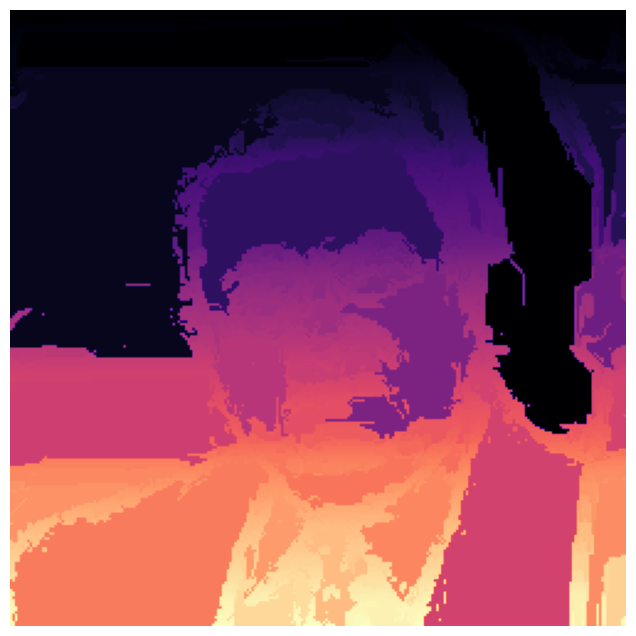

In [169]:
path = "../../data/inputs/Abel_Pacheco_0002.jpg"
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

labels, label_counts = region_labelling(img_lab, img_lab.shape[0] * img_lab.shape[1] // 8)

plt.figure(figsize = (8,8))
plt.imshow(labels,cmap = 'magma')
plt.axis('off')
plt.show()

In [170]:
def noise_image(grey_scale_image,labelled_image,label_frequency,l1,minl1,maxl1,l2,minl2,maxl2):
    
    grey_scale_image = grey_scale_image/np.max(grey_scale_image)
    h,w = grey_scale_image.shape
    
    label_frequency_vals = np.array(list(label_frequency.values()))
    noisy_image = np.empty((h,w),dtype = int)
    number_of_parents = len(label_frequency_vals)    
    grey_parent = np.zeros(number_of_parents)

    for i in range(h):
        for j in range(w):
            grey_parent[labelled_image[i][j]] += grey_scale_image[i][j]

    grey_parent = grey_parent/np.array(label_frequency_vals)

    threshold1 = (l1*(1 - grey_scale_image))**2
    threshold2 = (l2*(1 - grey_scale_image))**2
    rand_img = np.random.random((h,w))
    
    first_part = minl1*(rand_img <= threshold1) + maxl1*(rand_img > threshold1)
    second_part = minl2*(rand_img <= threshold2) + maxl2*(rand_img > threshold2)    
    points_selection = np.zeros((h,w),dtype = int)

    for i in range(h):
        for j in range(w):
            points_selection[i][j] = int(grey_scale_image[i][j] <= grey_parent[labelled_image[i][j]])
    
    noisy_image = first_part*points_selection + second_part*(1 - points_selection)

    return noisy_image

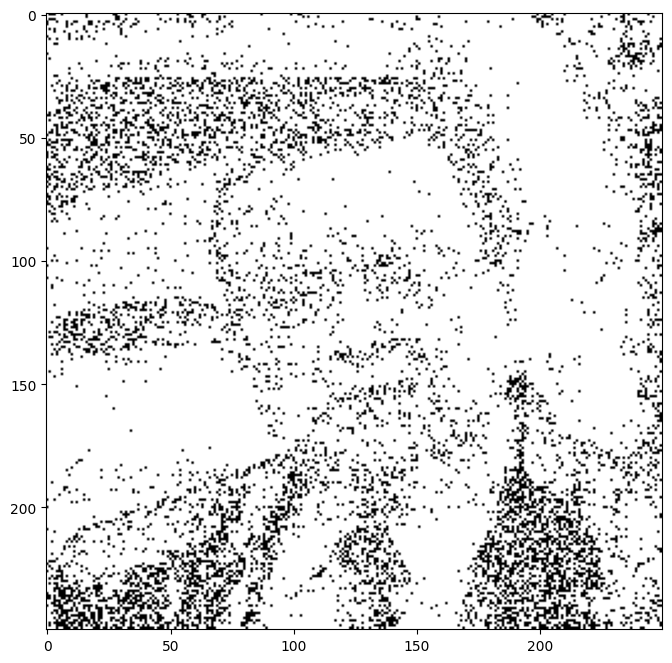

In [171]:
im_noise = noise_image(img_gray, labels, label_counts,0.7,0,255,0.3,0,255)
figure = plt.figure(figsize=(8,8))

plt.imshow(im_noise,cmap = 'gray')
plt.show()

In [172]:
def vector_field(grayImage,labelled_img, label_frequency,blur_sigma = 1,blur_size =7,threshold = 0.5):
    h,w = grayImage.shape[0],grayImage.shape[1]

    out = cv2.GaussianBlur(grayImage,(blur_size,blur_size),blur_sigma)
    outx = cv2.Sobel(out,cv2.CV_64F,1,0,ksize=3)
    outy = cv2.Sobel(out,cv2.CV_64F,0,1,ksize=3)
    rotate_out = np.concatenate((outx.reshape(h,w,1),np.array(-1*outy).reshape(h,w,1)),axis=2)/255
    
    bool_array = (rotate_out[:,:,1]<0).astype(int)
    replicate_bool = np.concatenate((bool_array.reshape(h,w,1),bool_array.reshape(h,w,1)),axis = 2)
    rotate_out = rotate_out*(1 - 2*replicate_bool)
    mean_vectors = np.zeros((len(label_frequency),2))
    variance_vectors = np.zeros((len(label_frequency),1))
    for i in range(h):
        for j in range(w):
            mean_vectors[labelled_img[i,j],:] += rotate_out[i,j,:] #np.reshape(rotate_out[i,j,:],1,2)
    
    for i in range(len(label_frequency)):
        mean_vectors[i,:] /= label_frequency[i]
    
    for i in range(h):
        for j in range(w):
            variance_vectors[labelled_img[i,j]] += np.sum((rotate_out[i,j,:] - mean_vectors[labelled_img[i,j],:])**2)

    for i in range(len(label_frequency)):
        variance_vectors[i] /= label_frequency[i]
    
    for i in range(h):
        for j in range(w):
            if variance_vectors[labelled_img[i,j]] <= threshold:
                rotate_out[i,j,:] = mean_vectors[labelled_img[i,j],:]
    
    sum_vals = (np.sum(rotate_out**2,axis = 2))**0.5 + np.exp(-2)
    replicate = np.concatenate((sum_vals.reshape(h,w,1),sum_vals.reshape(h,w,1)),axis = 2)
    rotate_out = rotate_out / replicate

    return rotate_out

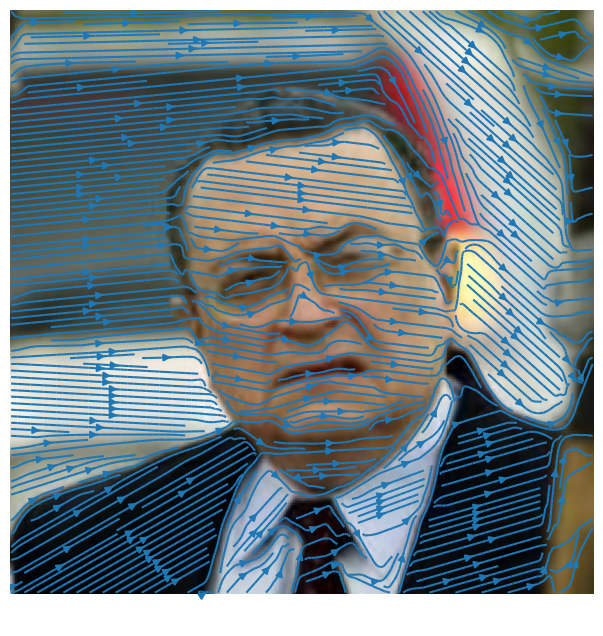

In [173]:
streamlines = vector_field(img_gray, labels, label_counts)
figure = plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
X, Y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
plt.streamplot(X, Y, streamlines[:, :, 1], streamlines[:, :, 0], density=(3, 3))
plt.show()

In [174]:
def bilinear(img, coord, norm=True):
    
    h,w= img.shape[0],img.shape[1]
    a = int(np.floor(coord[0]))
    b = int(np.floor(coord[1]))
    alpha = coord[0]  - a
    beta = coord[1]  - b

    if a < 0 : a = 0
    elif a >= h: a = h - 1
    if b < 0 : b = 0
    elif b >= w: b = w - 1

    if a + 1 < 0 : da = 0
    elif a + 1 >= h: da = h - 1
    else: da = a + 1
    if b + 1 < 0 : db = 0
    elif b + 1 >= w: db = w - 1
    else: db = b + 1
    
    line1 = img[a, b] * (1 - beta) + img[a, db] * beta
    line2 = img[da, b] * (1 - beta) + img[da, db] * beta
    result = line1 * (1 - alpha) + line2 * alpha

    if norm:
        result /= np.sum(result ** 2) + 0.0001

    return result

In [175]:
def lic(noisy_image,vectorlines,radi_field = 25,kernelsize = 5):
    
    h,w = noisy_image.shape
    checked = np.zeros((h,w))
    output = np.zeros((h,w))

    filter = np.arange(1,kernelsize+1)
    filter = np.minimum(filter,filter[::-1])
    filter = filter/np.sum(filter)
    def func(y,t):
        return bilinear(vectorlines,y)

    coordinates = []    
    for i in range(h):
        for j in range(w):
            coordinates.append((i,j))

    random.shuffle(coordinates)
    for sp_pix in coordinates:
        i,j = sp_pix
        if checked[i][j] == 0:

            st_line = np.zeros((2*radi_field + 1,2))
            st_line[radi_field][0] = i 
            st_line[radi_field][1] = j 
            
            move_ahead = scipy.integrate.odeint(func,[i,j],np.arange(radi_field + 1),rtol=1e-2,atol=1e-2)
            move_back = scipy.integrate.odeint(func,[i,j],-np.arange(radi_field ),rtol=1e-2,atol=1e-2)

            st_line[radi_field:,:] = move_ahead
            st_line[:radi_field,:] = move_back[::-1]
            
            vals = []
            for k in range(2*radi_field + 1):
                vals.append(bilinear(noisy_image,st_line[k,:],False))

            vals = np.array(vals)
            conv_vals = scipy.signal.convolve(vals,filter,mode = 'same')
            ii_lin = np.floor(st_line[kernelsize :-(kernelsize ),0]).astype(int)
            jj_lin = np.floor(st_line[kernelsize :-(kernelsize ),1]).astype(int)

            conv_lin = conv_vals[kernelsize :-(kernelsize )]
            for i in range(len(ii_lin)):
                if ii_lin[i] >= 0 and ii_lin[i] < h and jj_lin[i] >= 0 and jj_lin[i] < w:
                    checked[ii_lin[i]][jj_lin[i]] += 1
                    output[ii_lin[i]][jj_lin[i]] += conv_lin[i]

    return (output/checked)/np.max(output/checked)


In [176]:
gg = lic(im_noise,streamlines)

/home/rudeninja/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


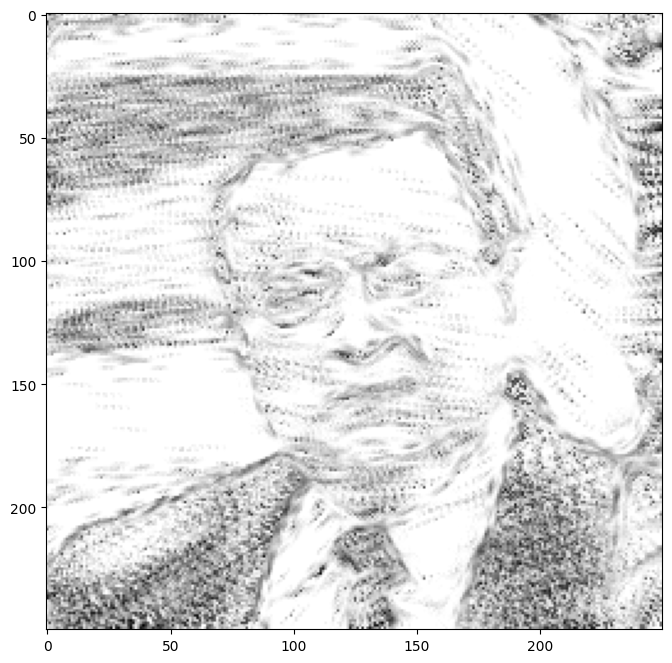

In [177]:
figure = plt.figure(figsize=(8,8))
plt.imshow(gg,cmap = 'gray')
plt.show()

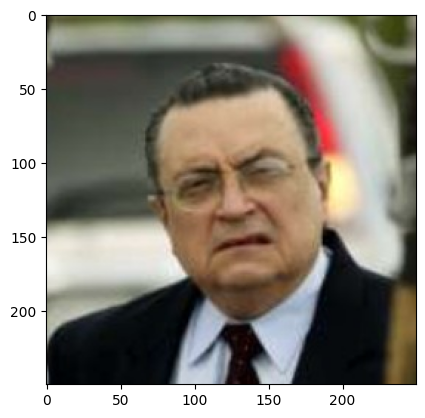

In [178]:
import matlab.engine

image = cv2.imread(path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.normalize(image.astype(np.float32), None, 0.0, 1.0, cv2.NORM_MINMAX)
plt.imshow(image)

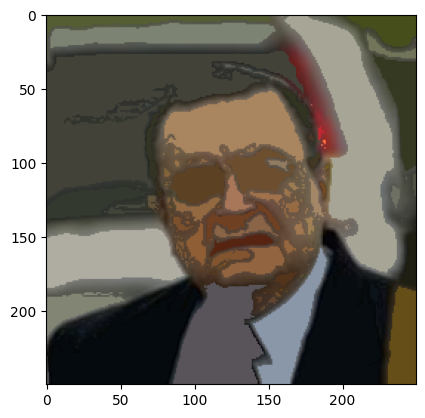

In [179]:
out = segment_color(image,0.03,18.0,0.9,50.0)
plt.imshow(out)


(250, 250)
1.0


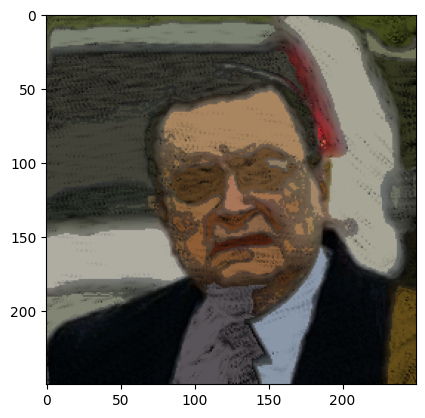

In [180]:
print(gg.shape)
print(np.amax(gg))
outpre = np.dstack((gg,gg,gg))


# outpre = (outpre-np.amin(outpre))/(np.amax(outpre)-np.amin(outpre))

outfinal = outpre*out

plt.imshow(outfinal)

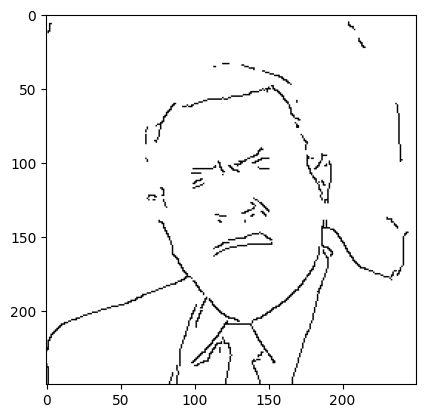

In [181]:
image2 = cv2.imread(path)

imgrey = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
imgrey = imgrey.astype(np.uint8)
outline = cv2.Canny(imgrey,175,200)
outline  = cv2.normalize(outline.astype(np.float32), None, 0.0, 1.0, cv2.NORM_MINMAX)
plt.imshow(1-outline,cmap='gray')

outline_final = np.dstack((1-outline,1-outline,1-outline))

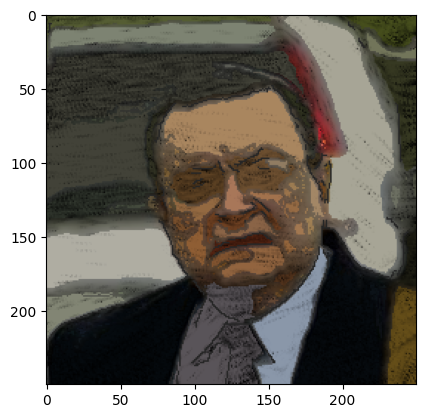

In [182]:
outfinal2 = outfinal*outline_final + 0.15*(1-outline_final)
plt.imshow(outfinal2)

In [183]:
outfinal3 = np.dstack((outfinal2[:,:,2],outfinal2[:,:,1],outfinal2[:,:,0]))
cv2.imwrite('Abel_Pacheco_002_output.jpg',outfinal3*255)

True